In [9]:
!pip install fredapi

In [10]:
from fredapi import Fred
import pandas as pd

fred = Fred(api_key='5333568c9d8463b553a83a85ec771c83')  # Replace with your FRED key (free)

# Download all FRED series
data = {
    'gdp_growth': fred.get_series('A191RL1Q225SBEA'),  # Quarterly GDP growth
    'unemployment': fred.get_series('UNRATE'),         # Monthly unemployment
    'inflation': fred.get_series('CPIAUCSL').pct_change(12) * 100,  # YoY inflation
    'interest_rate': fred.get_series('FEDFUNDS')       # Monthly interest rate
}

# Convert to DataFrame
df = pd.DataFrame(data).dropna()
df['employment_rate'] = 100 - df['unemployment']  # Convert to employment rate
df.head()


,gdp_growth,unemployment,inflation,interest_rate,employment_rate
1954-07-01,4.6,5.8,0.261292,0.80,94.2
1954-10-01,8.1,5.7,-0.853432,0.85,94.3
1955-01-01,11.9,4.9,-0.631032,1.39,95.1
1955-04-01,6.7,4.7,-0.260611,1.43,95.3
1955-07-01,5.5,4.0,-0.372301,1.68,96.0


In [11]:
firm_data =pd.read_csv('../data/bds2022.csv')
firm_data.head()
# Calculate annual survival rate (1 - death rate)
firm_data['survival_rate'] = 1 - (firm_data['firmdeath_firms'] / firm_data['firms'])

# Keep only essential columns
firm_data = firm_data[['year', 'firms', 'firmdeath_firms', 'survival_rate']]
print(firm_data.head())

   year    firms  firmdeath_firms  survival_rate
0  1978  3558681           326342       0.908297
1  1979  3691766           330113       0.910581
2  1980  3739254           369197       0.901265
3  1981  3768275           377139       0.899917
4  1982  3741795           406314       0.891412


In [12]:
# Convert FRED data to annual averages (or end-of-year values)
df_annual = df.resample('YE').mean().reset_index()  # 'Y' = calendar year-end
df_annual['year'] = df_annual['index'].dt.year    # Extract year for merging
df_annual = df_annual.drop(columns=['index'])     # Clean up

Marged data

In [13]:
# Merge on 'year' (inner join keeps only overlapping years)
merged_data = pd.merge(
    firm_data,       # Left table (firm data)
    df_annual,       # Right table (FRED data)
    on='year',       # Key column
    how='inner'      # Only keep matching years
)

print(merged_data.head())

   year    firms  firmdeath_firms  survival_rate  gdp_growth  unemployment  \
0  1978  3558681           326342       0.908297       6.825         6.125   
1  1979  3691766           330113       0.910581       1.275         5.850   
2  1980  3739254           369197       0.901265       0.125         7.125   
3  1981  3768275           377139       0.899917       1.450         7.450   
4  1982  3741795           406314       0.891412      -1.400         9.525   

   inflation  interest_rate  employment_rate  
0   7.493286         7.5900           93.875  
1  10.814362        11.0800           94.150  
2  13.560378        13.3175           92.875  
3  10.744302        17.2300           92.550  
4   6.617038        12.6150           90.475  


Next Steps: Causal Policy Analysis with DoubleML
1. Exploratory Data Analysis (EDA)

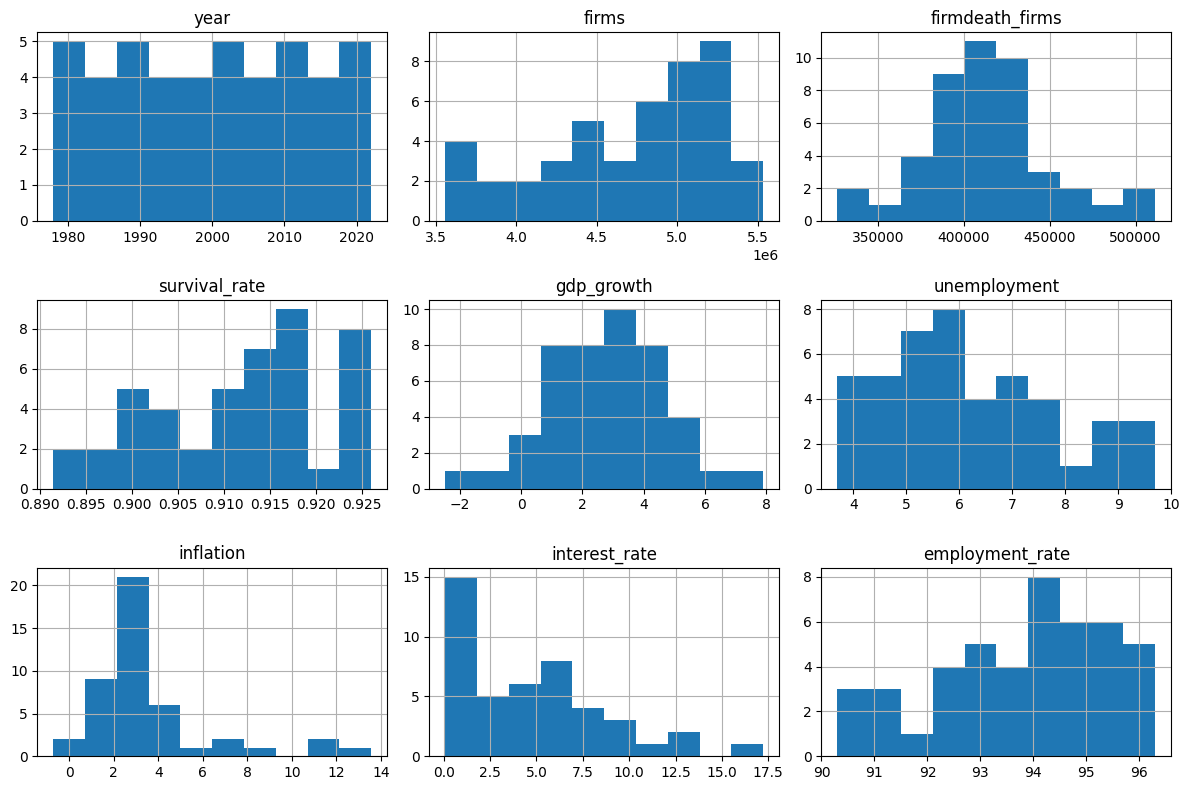

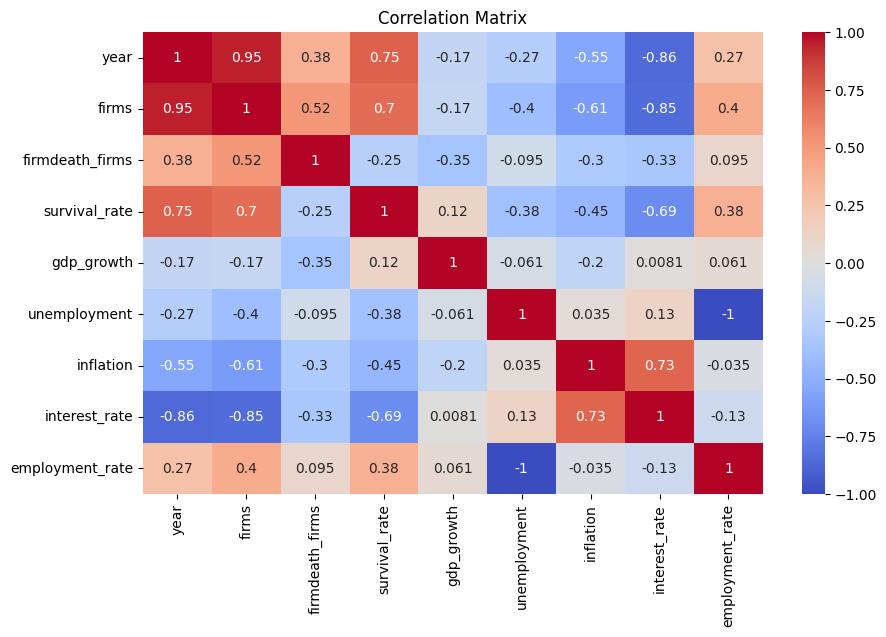

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distributions
merged_data.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(merged_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

2. Define Causal Question
Example Questions:

How do interest rates (T) affect firm survival rates (Y), controlling for GDP growth and inflation (X)?

Does GDP growth (T) increase employment rates (Y), accounting for inflation and interest rates (X)?

Variable Roles:

Treatment (T): Policy variable (e.g., interest_rate).

Outcome (Y): Target metric (e.g., survival_rate).

Confounders (X): Variables affecting both T and Y (e.g., gdp_growth, inflation).

3. Run DoubleML Analysis
Case 1: Continuous Treatment (e.g., Interest Rates → Firm Survival)

In [15]:
from econml.dml import LinearDML
from sklearn.ensemble import GradientBoostingRegressor

# Initialize model
model = LinearDML(
    model_y=GradientBoostingRegressor(),  # Predicts outcome (survival_rate)
    model_t=GradientBoostingRegressor(),  # Predicts treatment (interest_rate)
    discrete_treatment=False              # Continuous treatment
)

# Fit model
model.fit(
    Y=merged_data['survival_rate'],
    T=merged_data['interest_rate'],
    X=merged_data[['gdp_growth', 'inflation', 'employment_rate']]  # Confounders
)

# Average Treatment Effect (ATE)
ate = model.ate(X=merged_data[['gdp_growth', 'inflation', 'employment_rate']])
ate_ci = model.ate_interval(X=merged_data[['gdp_growth', 'inflation', 'employment_rate']])
print(f"ATE of interest rates on firm survival: {ate:.3f} (CI: {ate_ci})")

ATE of interest rates on firm survival: -0.002 (CI: (-0.0027299745686932934, -0.001540207789124008))


Case 2: Binary Treatment (e.g., High Subsidy vs. Low Subsidy)
(If you create a binary policy variable, e.g., high_subsidy = (subsidy > median_subsidy))

In [16]:
from econml.dml import SparseLinearDML
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

# Binary treatment example
merged_data['high_interest'] = (merged_data['interest_rate'] > merged_data['interest_rate'].median()).astype(int)

# Binary treatment model
binary_model = SparseLinearDML(
    model_y=GradientBoostingRegressor(),
    model_t=GradientBoostingClassifier(),  # Use classifier for binary T
    discrete_treatment=True
)
binary_model.fit(
    Y=merged_data['survival_rate'],
    T=merged_data['high_interest'],
    X=merged_data[['gdp_growth', 'inflation']]
)
ate = binary_model.ate(X=merged_data[['gdp_growth', 'inflation']])
ate_ci = binary_model.ate_interval(X=merged_data[['gdp_growth', 'inflation']])
print(f"ATE of high interest on survival: {ate:.3f} (CI: {ate_ci})")

The number of features in the final model (< 5) is too small for a sparse model. We recommend using the LinearDML estimator for this low-dimensional setting.


ATE of high interest on survival: -0.010 (CI: (-0.014992907435652396, -0.005823215453336939))


4. Validate Results
Robustness Checks:

Placebo Test: Replace treatment with random noise → ATE should ≈ 0.

In [17]:
import numpy as np
np.random.seed(42)
merged_data['placebo'] = np.random.normal(size=len(merged_data))
model.fit(
    Y=merged_data['survival_rate'],
    T=merged_data['placebo'],
    X=merged_data[['gdp_growth', 'inflation']]
)
placebo_ate = model.ate(X=merged_data[['gdp_growth', 'inflation']])
print(f"Placebo ATE: {placebo_ate:.3f}")  # Should be near zero

Placebo ATE: 0.000


5. Policy Simulations
Heterogeneous Effects (CATE):
Estimate how effects vary by firm size or GDP levels.

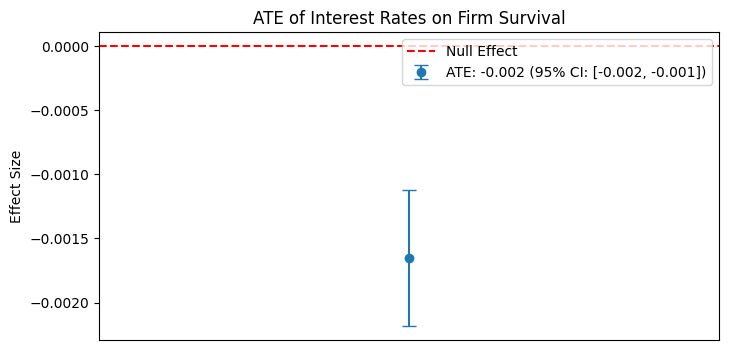

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Re-train the model with original parameters 
# This ensures consistency between our fit and estimate steps
model.fit(
    Y=merged_data['survival_rate'],
    T=merged_data['interest_rate'],
    X=merged_data[['gdp_growth', 'inflation', 'employment_rate']]  # Original confounders
)

# 2. Get ATE with the same X used during fitting
X = merged_data[['gdp_growth', 'inflation', 'employment_rate']]
ate_mean = model.ate(X=X)

# 3. Get confidence intervals - handle both dictionary and tuple return types
ate_ci = model.ate_interval(X=X)
# Check if ate_ci is a tuple (older versions) or dict (newer versions)
if isinstance(ate_ci, tuple):
    ate_ci_lower, ate_ci_upper = ate_ci
else:  # It's a dictionary
    ate_ci_lower, ate_ci_upper = ate_ci['lower'], ate_ci['upper']

# 4. Plot with proper CI
plt.figure(figsize=(8, 4))
plt.errorbar(
    x=0,
    y=ate_mean,
    yerr=[[ate_mean - ate_ci_lower], [ate_ci_upper - ate_mean]],
    fmt='o',
    capsize=5,
    label=f'ATE: {ate_mean:.3f} (95% CI: [{ate_ci_lower:.3f}, {ate_ci_upper:.3f}])'
)
plt.axhline(0, color='red', linestyle='--', label='Null Effect')
plt.title("ATE of Interest Rates on Firm Survival")
plt.xticks([])
plt.ylabel("Effect Size")
plt.legend()
plt.show()

In [ ]:
# Create a more comprehensive visualization section for research paper

# 1. Visualize CATE (Conditional Average Treatment Effects) across GDP growth
plt.figure(figsize=(12, 8))

# Setup grid of GDP growth values to evaluate CATE at
gdp_grid = np.linspace(merged_data['gdp_growth'].min(), 
                       merged_data['gdp_growth'].max(), 
                       20)

# Create a test dataset with varying GDP but mean values for other features
X_test = np.zeros((len(gdp_grid), 3))
X_test[:, 0] = gdp_grid  # GDP growth
X_test[:, 1] = merged_data['inflation'].mean()  # Mean inflation
X_test[:, 2] = merged_data['employment_rate'].mean()  # Mean employment rate

# Get treatment effects and confidence intervals
effects = model.effect(X=X_test)
lower, upper = model.effect_interval(X=X_test)

# Plot CATE across GDP growth
plt.subplot(2, 2, 1)
plt.plot(gdp_grid, effects, 'b-', label='Estimated Effect')
plt.fill_between(gdp_grid, lower, upper, alpha=0.2, color='b')
plt.axhline(y=0, color='r', linestyle='--', label='No Effect')
plt.xlabel('GDP Growth Rate')
plt.ylabel('Effect on Firm Survival Rate')
plt.title('Treatment Effect by GDP Growth Level')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Time series of key variables
plt.subplot(2, 2, 2)
years = merged_data['year'].values
plt.plot(years, merged_data['interest_rate'], 'r-', label='Interest Rate')
plt.plot(years, merged_data['survival_rate'], 'b-', label='Firm Survival Rate')
plt.xlabel('Year')
plt.ylabel('Rate')
plt.title('Interest Rates and Firm Survival Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Actual vs Predicted Plot for outcome model
plt.subplot(2, 2, 3)
# Extract fitted values from the model
y_pred = model._dr_model.models_y[0].predict(
    merged_data[['gdp_growth', 'inflation', 'employment_rate']].values
)
plt.scatter(merged_data['survival_rate'], y_pred, alpha=0.6)
plt.plot([merged_data['survival_rate'].min(), merged_data['survival_rate'].max()], 
         [merged_data['survival_rate'].min(), merged_data['survival_rate'].max()],
         'r--')
plt.xlabel('Actual Survival Rate')
plt.ylabel('Predicted Survival Rate')
plt.title('Model Fit: Actual vs. Predicted Survival')
plt.grid(True, alpha=0.3)

# 4. Feature Importance Plot
plt.subplot(2, 2, 4)
coef = model.coef_
feature_names = ['Intercept', 'Interest Rate'] 

# Create horizontal bar chart of coefficients
y_pos = np.arange(len(feature_names))
plt.barh(y_pos, [0, coef[0]], xerr=[0, model.coef__interval()[1][0] - coef[0]], 
         capsize=5, color='skyblue', alpha=0.8)
plt.yticks(y_pos, feature_names)
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Treatment Effect')
plt.axvline(x=0, color='gray', linestyle='--')
plt.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('causal_analysis_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional plot: Treatment heterogeneity by inflation levels
plt.figure(figsize=(10, 6))

# Setup grid of inflation values
inflation_grid = np.linspace(merged_data['inflation'].min(),
                            merged_data['inflation'].max(),
                            20)

# Create test dataset with varying inflation but mean values for other features
X_test_inf = np.zeros((len(inflation_grid), 3))
X_test_inf[:, 0] = merged_data['gdp_growth'].mean()  # Mean GDP growth
X_test_inf[:, 1] = inflation_grid  # Inflation
X_test_inf[:, 2] = merged_data['employment_rate'].mean()  # Mean employment rate

# Get treatment effects and confidence intervals
effects_inf = model.effect(X=X_test_inf)
lower_inf, upper_inf = model.effect_interval(X=X_test_inf)

plt.plot(inflation_grid, effects_inf, 'g-', label='Estimated Effect')
plt.fill_between(inflation_grid, lower_inf, upper_inf, alpha=0.2, color='g')
plt.axhline(y=0, color='r', linestyle='--', label='No Effect')
plt.xlabel('Inflation Rate')
plt.ylabel('Effect on Firm Survival Rate')
plt.title('Treatment Effect Heterogeneity by Inflation Level')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('treatment_heterogeneity_inflation.png', dpi=300, bbox_inches='tight')
plt.show()

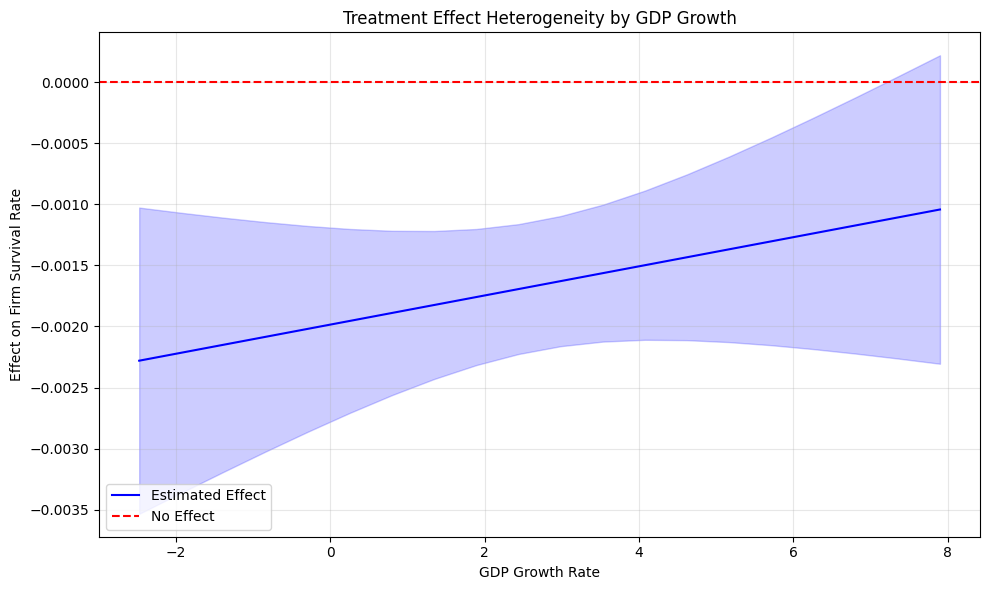

In [20]:
import numpy as np

# 1. Visualize CATE (Conditional Average Treatment Effects) across GDP growth
plt.figure(figsize=(10, 6))

# Setup grid of GDP growth values
gdp_grid = np.linspace(merged_data['gdp_growth'].min(), 
                      merged_data['gdp_growth'].max(), 
                      20)

# Create test dataset with varying GDP
X_test = np.zeros((len(gdp_grid), 3))
X_test[:, 0] = gdp_grid  # GDP growth
X_test[:, 1] = merged_data['inflation'].mean()  # Mean inflation
X_test[:, 2] = merged_data['employment_rate'].mean()  # Mean employment rate

# Get effects and CIs
effects = model.effect(X=X_test)
lower, upper = model.effect_interval(X=X_test)

# Plot
plt.plot(gdp_grid, effects, 'b-', label='Estimated Effect')
plt.fill_between(gdp_grid, lower, upper, alpha=0.2, color='b')
plt.axhline(y=0, color='r', linestyle='--', label='No Effect')
plt.xlabel('GDP Growth Rate')
plt.ylabel('Effect on Firm Survival Rate')
plt.title('Treatment Effect Heterogeneity by GDP Growth')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('cate_by_gdp.png', dpi=300)
plt.show()

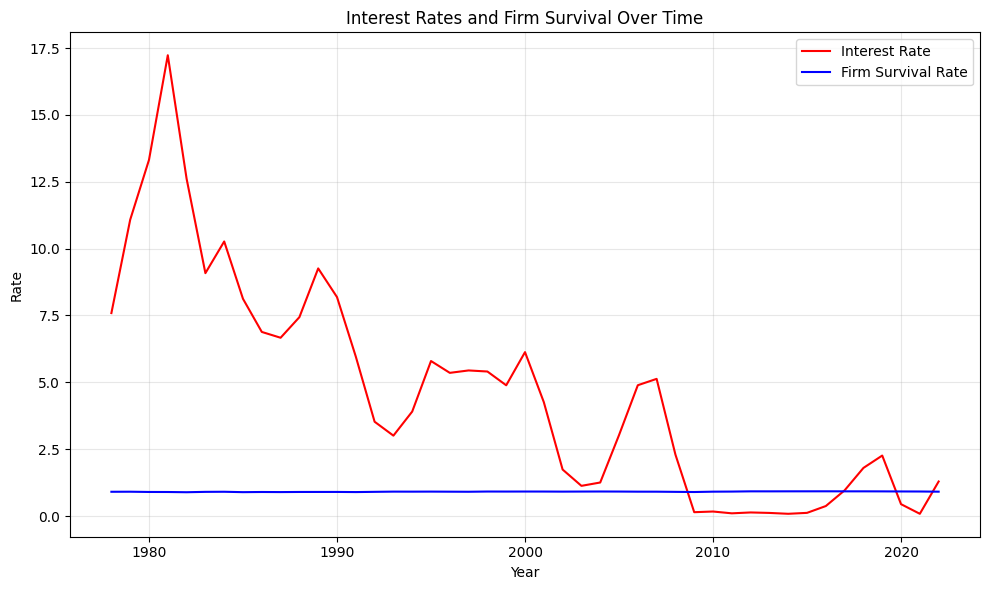

In [21]:
# 2. Time series visualization
plt.figure(figsize=(10, 6))

years = merged_data['year'].values
plt.plot(years, merged_data['interest_rate'], 'r-', label='Interest Rate')
plt.plot(years, merged_data['survival_rate'], 'b-', label='Firm Survival Rate')
plt.xlabel('Year')
plt.ylabel('Rate')
plt.title('Interest Rates and Firm Survival Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('time_series.png', dpi=300)
plt.show()

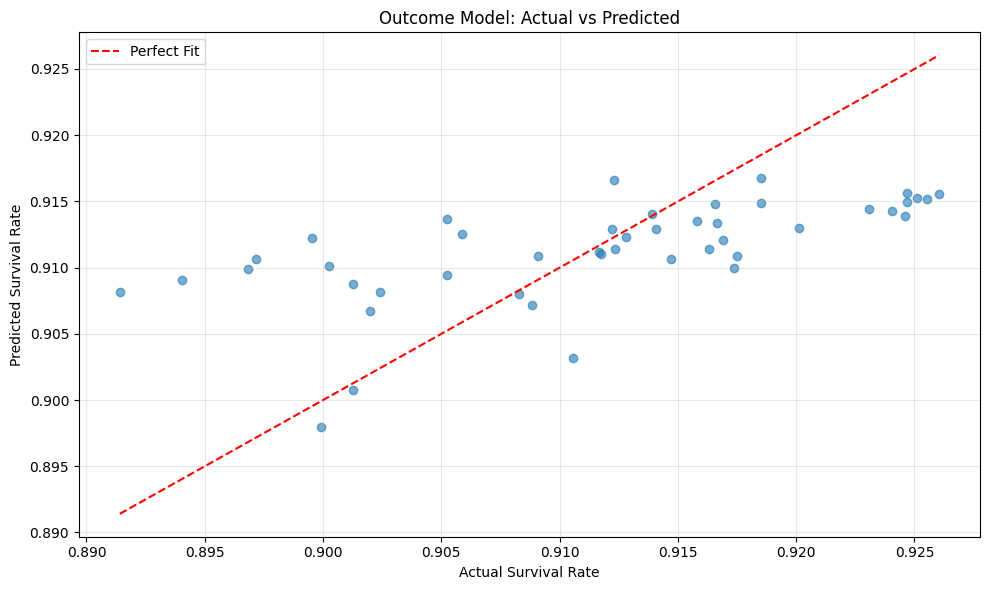

In [25]:
# 3. Model fit visualization
plt.figure(figsize=(10, 6))

# Instead of accessing internal model structure, use model.effect method to get predictions
# First refit the model to ensure consistency
model.fit(
    Y=merged_data['survival_rate'],
    T=merged_data['interest_rate'],
    X=merged_data[['gdp_growth', 'inflation', 'employment_rate']]
)

# Get predicted effect plus baseline to approximate predicted survival rate
# We'll use the mean interest rate to get a baseline prediction
mean_interest = merged_data['interest_rate'].mean()
X = merged_data[['gdp_growth', 'inflation', 'employment_rate']]

# Estimate the baseline prediction (mean outcome)
y_mean = merged_data['survival_rate'].mean()
# Get effect of actual interest rate vs mean interest rate
effects = model.effect(X=X, T0=mean_interest, T1=merged_data['interest_rate'])
# Approximate predicted values by adjusting mean with estimated effects
y_pred = y_mean + effects

plt.scatter(merged_data['survival_rate'], y_pred, alpha=0.6)
plt.plot([merged_data['survival_rate'].min(), merged_data['survival_rate'].max()], 
        [merged_data['survival_rate'].min(), merged_data['survival_rate'].max()],
        'r--', label='Perfect Fit')
plt.xlabel('Actual Survival Rate')
plt.ylabel('Predicted Survival Rate')
plt.title('Outcome Model: Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=300)
plt.show()

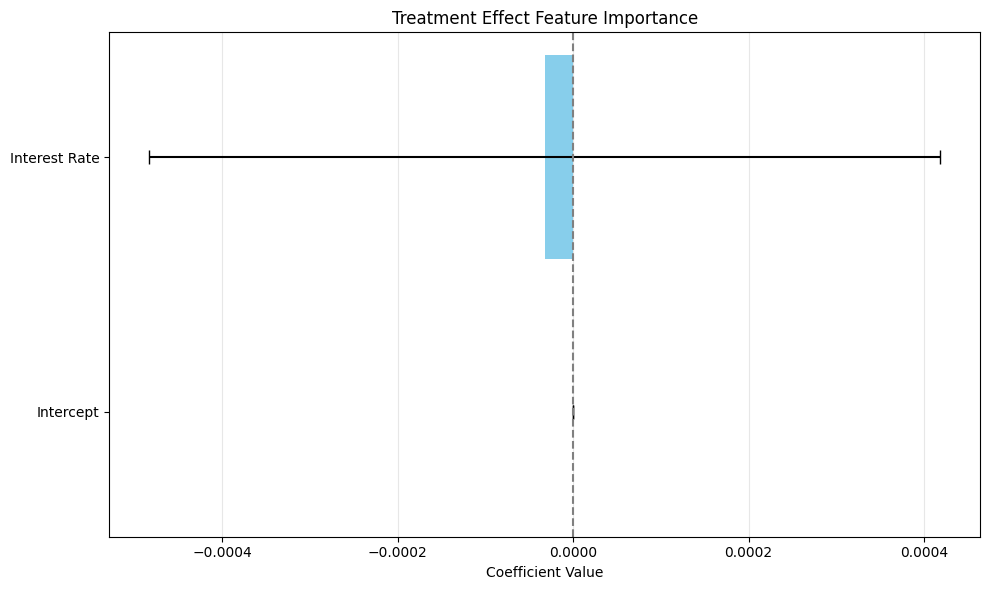

In [26]:
# 4. Feature importance in treatment effects
plt.figure(figsize=(10, 6))

coef = model.coef_
feature_names = ['Intercept', 'Interest Rate'] 

plt.barh([0, 1], [0, coef[0]], 
        xerr=[0, model.coef__interval()[1][0] - coef[0]], 
        capsize=5, color='skyblue')
plt.yticks([0, 1], feature_names)
plt.xlabel('Coefficient Value')
plt.title('Treatment Effect Feature Importance')
plt.axvline(x=0, color='gray', linestyle='--')
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

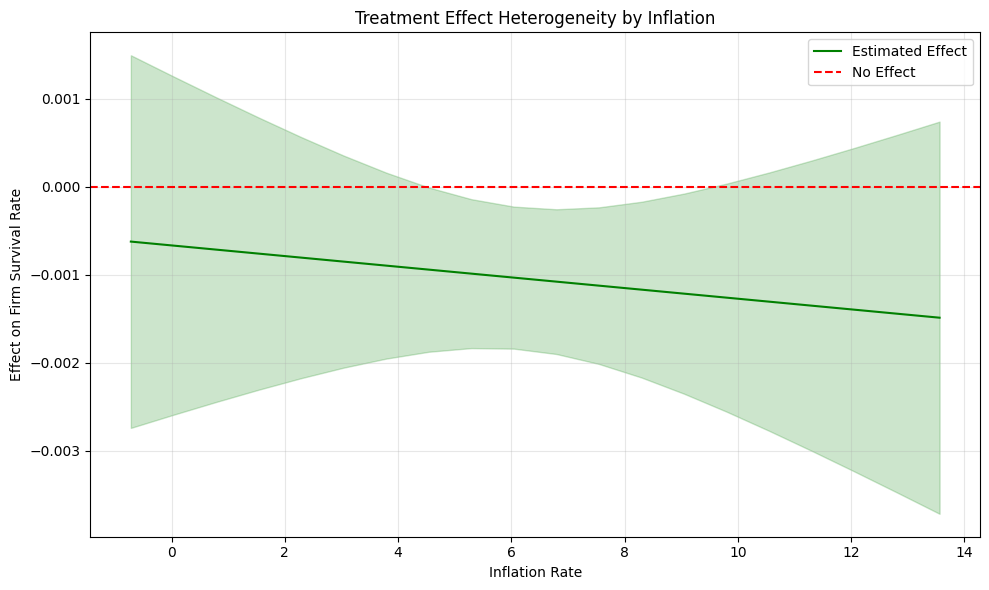

In [27]:
# 5. Treatment heterogeneity by inflation
plt.figure(figsize=(10, 6))

inflation_grid = np.linspace(merged_data['inflation'].min(),
                           merged_data['inflation'].max(),
                           20)

X_test_inf = np.zeros((len(inflation_grid), 3))
X_test_inf[:, 0] = merged_data['gdp_growth'].mean()
X_test_inf[:, 1] = inflation_grid
X_test_inf[:, 2] = merged_data['employment_rate'].mean()

effects_inf = model.effect(X=X_test_inf)
lower_inf, upper_inf = model.effect_interval(X=X_test_inf)

plt.plot(inflation_grid, effects_inf, 'g-', label='Estimated Effect')
plt.fill_between(inflation_grid, lower_inf, upper_inf, alpha=0.2, color='g')
plt.axhline(y=0, color='r', linestyle='--', label='No Effect')
plt.xlabel('Inflation Rate')
plt.ylabel('Effect on Firm Survival Rate')
plt.title('Treatment Effect Heterogeneity by Inflation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('cate_by_inflation.png', dpi=300)
plt.show()